In [124]:
#utilities

# Show the figures / plots inside the notebook
# instead of io.imshow(gaussedImg) and plt.show() each time
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


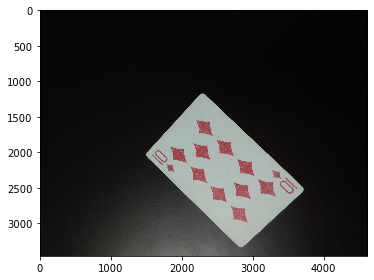

In [125]:
#initial step

from skimage import data, io, filters, feature, measure, transform
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
import numpy as np

img=io.imread('10D0.jpg');
io.imshow(img)
plt.show()

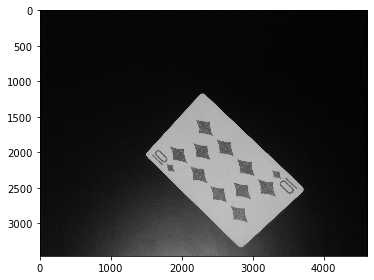

(3456, 4608, 3)


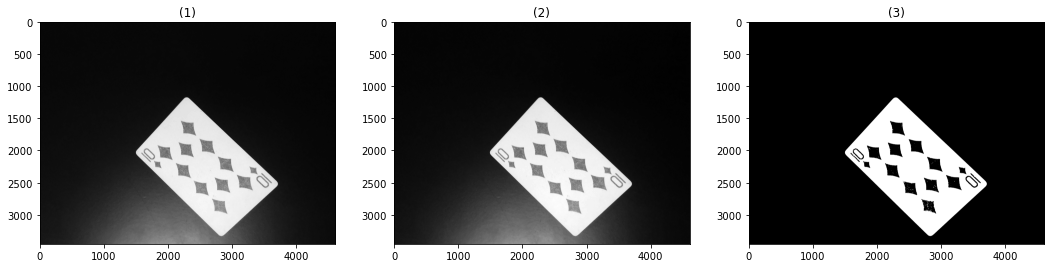

In [126]:
#preprocessing step

grayImg=rgb2gray(img);
io.imshow(grayImg)
plt.show()

if(np.max(grayImg) < 1):
    grayImg=grayImg*255
    
gaussedImg=filters.gaussian(grayImg)

addedConst=120
imgH, imgW = np.shape(img)[:2]
print(np.shape(img))
randLvl = grayImg[int(imgH/100)][int(imgW/2)]
thresh = randLvl + addedConst
threImg=np.copy(gaussedImg)
threImg[threImg>thresh]=255
threImg[threImg<=thresh]=0

show_images([grayImg,gaussedImg,threImg])

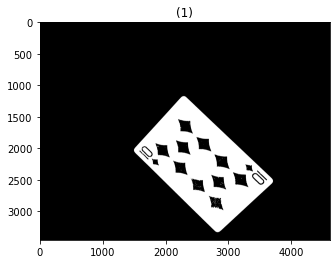

[8737, 5]
[13, 5]
[1057, 5]
[13, 5]
[11, 5]
[19, 4]
[13, 5]
[11, 5]
[33, 4]
[5, 5]
[11, 5]
[41, 3]
[7, 5]
[13, 5]
[31, 3]
[11, 5]
[13, 4]
[5, 5]
[7, 5]
[23, 3]
[7, 5]
[7, 5]
[1055, 5]
[5, 5]
[5, 5]
[7, 5]
[993, 5]
[19, 4]
[19, 5]
[11, 5]
[17, 4]
[9, 5]
[5, 5]
[5, 5]
[9, 3]
[17, 5]
[5, 5]
[1025, 5]
[9, 5]
[13, 5]
[13, 5]
[11, 5]
[5, 5]
[7, 5]
[13, 4]
[5, 5]
[5, 5]
[17, 4]
[5, 5]
[9, 5]
[21, 3]
[13, 4]
[5, 5]
[11, 5]
[71, 4]
[89, 3]
[817, 4]
[5, 5]
[13, 5]
[27, 4]
[17, 5]
[17, 4]
[5, 5]
[615, 3]
[13, 5]
[7, 5]
[5, 5]
[21, 4]
[5, 5]
[5, 5]
[13, 4]
[13, 4]
[21, 4]
[7, 5]
[5, 5]
[9, 5]
[19, 4]
[15, 4]
[7, 5]
[9, 5]
[5, 5]
[13, 5]
[747, 3]
[13, 5]
[19, 4]
[7, 5]
[9, 5]
[9, 5]
[11, 5]
[9, 5]
[13, 5]
[21, 4]
[7, 5]
[5, 5]
[5, 5]
[11, 4]
[21, 5]
[11, 5]
[19, 5]
[7, 5]
[9, 5]
[5, 5]
[19, 4]
[27, 4]
[1097, 5]
[5, 5]
[31, 4]
[13, 4]
[17, 4]
[17, 4]
[11, 4]
[5, 5]
[7, 5]
[19, 5]
[5, 5]
[11, 4]
[11, 5]
[9, 5]
[21, 4]
[5, 5]
[25, 5]
[5, 5]
[17, 4]
[11, 5]
[13, 5]
[5, 5]
[15, 5]
[505, 5]
[25, 5]
[15, 

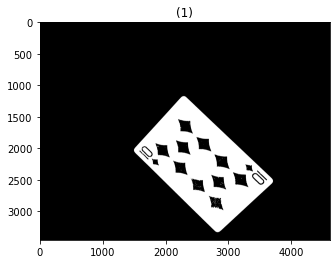

[[3332.5 2825. ]
 [2047.  1495.5]
 [1176.5 2268. ]
 [2507.  3700.5]
 [3332.5 2825. ]]


In [127]:
#!(Edge detector) + find contours step

#calculate the distance between two points
def CalcDist(p1,p2):
    p1=np.copy(p1)
    p2=np.copy(p2)
    dist=np.sqrt((((p1-p2)**2).sum()))
    return dist

#calculate the perimeter of a contour
def CalcPerimeter(contour):
    ret=0
    prev=contour[-1]
    for cur in contour:
        ret+=CalcDist(cur,prev)
        prev=cur
    return ret

#caculate angle of three points using law of cosines
#arccos((P12^2 + P13^2 - P23^2) / (2 * P12 * P13))
def CalcAngle(points):
    p12=CalcDist(points[0],points[1])
    p13=CalcDist(points[2],points[1])
    p23=CalcDist(points[0],points[2])

    angle=np.arccos((p12**2+p13**2-p23**2)/(2*p12*p13))
    return angle*180/np.arccos(-1)

#caculate Area a polygon using Shoelace formula
def CalcArea(x,y):
    area=0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
    return area


maxAngle=100
minAngle=80

maxArea=3000000
minArea=10000

#check if the contour is likely to be a card
def CheckContour(contour):
    
    if(len(contour)!=5):
        return False
    
    area=CalcArea(contour[:4,1],contour[:4,0])
    if(area > maxArea or area < minArea):
        return False
    
    points=np.copy(contour)
    points=np.vstack([points, points[1]])    
    
    for i in range(4):
        angle=CalcAngle(points[i:i+3])
        if(angle >maxAngle or angle < minAngle):
            return False;
    
    return True

# cannyImg=feature.canny(threImg)
cannyImg=np.copy(threImg)
show_images([cannyImg])
contours=measure.find_contours(cannyImg)

cards=[]
for contour in contours:
    perimeter=CalcPerimeter(contour)
    approx=measure.approximate_polygon(contour,.1*perimeter)
    if(CheckContour(approx)==True):
        cards.append(approx)
    print([len(contour),len(approx)])
    
show_images([cannyImg])
print(cards[0])


1


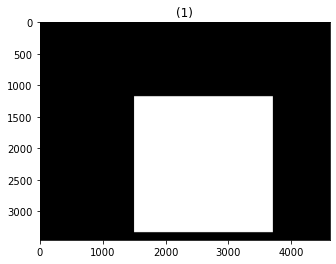

In [128]:
print(len(cards))
tempImg=np.zeros(np.shape(threImg))
for card in cards:
    rMin=int(np.min(card[:,0]))
    rMax=int(np.max(card[:,0]))
    cMin=int(np.min(card[:,1]))
    cMax=int(np.max(card[:,1]))
    tempImg[rMin:rMax,cMin:cMax]=255;
    show_images([tempImg])    
    tempImg[rMin:rMax,cMin:cMax]=0;

#     print([rMin,rMax])
#     print([cMin,cMax])



In [ ]:
#sort the corners of the card
def SortCorners(corners):
    
    s = np.sum(pts, axis = 2)
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]

    diff = np.diff(pts, axis = -1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    
    
    
    

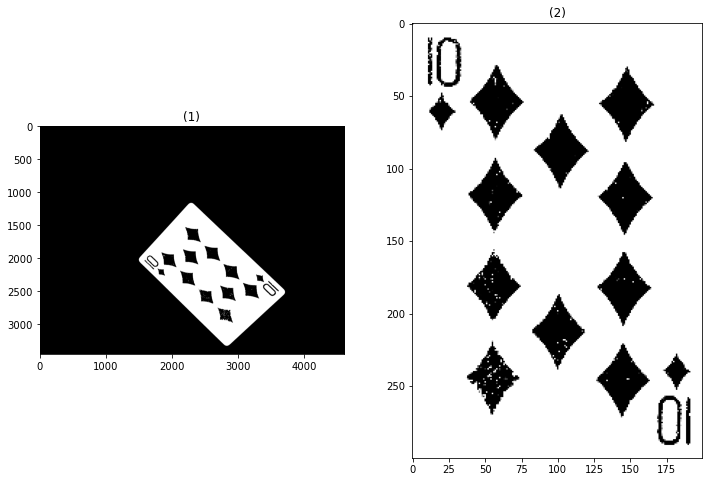

In [131]:
row=300
col=200


dst=cards[0][:4,[1,0]].astype(int)
# print(cards)

# dst=np.array([
#     [0,0],
#     [0,width],
#     [hieght,width],
#     [hieght,0]
# ])

src=np.array([
    [0,row],
    [0,0],
    [col,0],
    [col,row],
])

# print(src)
# print(dst)

transMatrix=transform.ProjectiveTransform()
transMatrix.estimate(src,dst)
warpedImg=transform.warp(threImg,transMatrix,output_shape=(row,col))
warpedImg=warpedImg
# print(np.max(warpedImg))

show_images([threImg,warpedImg])    

In [130]:
# temp=np.array([
#     [0,0],
#     [2,0],
#     [2,2],
#     [0,2]
# ])
# print(temp)
# print(temp[:2,1])

contour=contours[0]
perimeter=CalcPerimeter(contour)
approx=measure.approximate_polygon(contour,.1*perimeter)

area=CalcArea(approx[:4,1],approx[:4,0])
# area=CalcArea(temp[:4,1],temp[:4,0])
print(area)






2248880.0
